#### 基本設置 + 設cuda

In [51]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 16
num_classes = 4
learning_rate = 0.0005
num_epochs = 15

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [52]:
import torchvision.datasets as dset

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((480, 256)),  # 将图像调整为指定大小
    transforms.ToTensor(),           # 将图像转换为张量
])

# 加載圖像數據集，並只考慮指定的資料夾
# dataset = dset.ImageFolder(root='./Merge_Dataset/train', transform=transform)
dataset = dset.ImageFolder(root='./dataset_v2/train', transform=transform)


# 獲取相關信息
print(dataset.classes)  # 根據分的文件夾的名字來確定類別
print(dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...
print(len(dataset))  # 返回數據集的大小

print(dataset[0][0].size())  # 返回第一張圖片的大小

['boat', 'dolphin', 'fish', 'whale']
{'boat': 0, 'dolphin': 1, 'fish': 2, 'whale': 3}
102
torch.Size([3, 480, 256])


In [53]:
from torch.utils.data import DataLoader

# 加載圖像數據集，並只考慮指定的資料夾
train_dataset = dset.ImageFolder(root='./dataset_v2/train', transform=transform)
test_dataset = dset.ImageFolder(root='./dataset_v2/test', transform=transform)

# 创建 DataLoader 对象
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

7
3


#### 創立model

In [54]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(3,480,256)
        self.layer1 = self.conv_module(3, 8, 5, 1) #output_shape=(8,238,126)
        self.layer2 = self.conv_module(8, 14, 3, 1) #output_shape=(14,118,62)
        self.layer3 = self.conv_twice(14, 44, 3, 1) #output_shape=(44,58,30)
        self.layer4 = self.conv_twice(44, 20, 3, 1) #output_shape=(20,28,14)
        self.layer5 = self.conv_twice(20, 8, 5, 1) #output_shape=(8,12,5)
        # # Fully connected 1
        self.fc1 = nn.Linear(8*12*5, 4) 
        
    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        # Resize
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out
    
    def conv_module(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_twice(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a double convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),    # expand the channels
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )

In [55]:
import torchinfo

model = CNN_Model()
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
CNN_Model                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       608
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  16
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       1,022
│    └─ReLU: 2-6                         --
│    └─BatchNorm2d: 2-7                  28
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-9                       660
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      17,468
│    └─ReLU: 2-12                        --
│    └─BatchNorm2d: 2-13                 88
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-15                      900
│    └─ReLU: 2-16                        -

#### 訓練模型

In [56]:
import time
# File name.
modelSaveName = "ClassifiedModel_v3.pt"
# Create an optimizer.
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()
# Move model to "device".
model = model.to(device)

bestValidAcc = 0
for epoch in range(1, num_epochs+1):
  start_time = time.time()  # 計算每個epoch開始的時間
  # Training mode.
  model.train() 
  train_loss = 0.0
  for iter, (input, target) in enumerate(train_loader):
    # Move data to "device".
    input = input.to(device)
    target = target.to(device)
    # Clear optimizer gradients.
    optimizer.zero_grad()
    
    # Forward pass.
    output = model(input)
    # Compute the loss.
    loss=lossFunc(output, target)
    # Loss backward propagation.
    loss.backward()
    # Update all learnable parameters.
    optimizer.step()
    # update training loss
    train_loss += loss.item()

  # statistics
  # 計算每個樣本的平均損失
  train_loss = train_loss / len(train_loader)
  end_time = time.time()  # 計算每個epoch結束的時間
  epoch_time = end_time - start_time  # 計算每個epoch所花的時間
  print("Epoch:{}/{}, Time:{:.2f} seconds, Train Loss: {:.4f}".format(epoch, num_epochs, epoch_time, train_loss))

# 存檔
torch.save(model.state_dict(), modelSaveName, _use_new_zipfile_serialization=False)
print('Model saved to %s' % modelSaveName)

Epoch:1/15, Time:6.64 seconds, Train Loss: 1.1550
Epoch:2/15, Time:6.63 seconds, Train Loss: 0.5960
Epoch:3/15, Time:6.66 seconds, Train Loss: 0.3853
Epoch:4/15, Time:6.57 seconds, Train Loss: 0.2959
Epoch:5/15, Time:6.69 seconds, Train Loss: 0.1693
Epoch:6/15, Time:6.61 seconds, Train Loss: 0.0951
Epoch:7/15, Time:6.62 seconds, Train Loss: 0.0680
Epoch:8/15, Time:6.61 seconds, Train Loss: 0.0391
Epoch:9/15, Time:6.58 seconds, Train Loss: 0.0279
Epoch:10/15, Time:6.57 seconds, Train Loss: 0.0133
Epoch:11/15, Time:6.60 seconds, Train Loss: 0.0125
Epoch:12/15, Time:6.59 seconds, Train Loss: 0.0075
Epoch:13/15, Time:6.58 seconds, Train Loss: 0.0096
Epoch:14/15, Time:6.60 seconds, Train Loss: 0.0070
Epoch:15/15, Time:6.62 seconds, Train Loss: 0.0059
Model saved to ClassifiedModel_v3.pt


測試模型

In [57]:
model = CNN_Model()
model.load_state_dict(torch.load('ClassifiedModel_v3.pt'))

<All keys matched successfully>

In [58]:
correct = 0
total = 0
# 新增這邊記錄真實跟預測值
pred_list = []
label_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_list.extend(predicted.cpu().numpy())
        label_list.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

Accuracy of the network on the 37 test images: 86.48648648648648 %


印出一batch當中的每分類預測機率。

In [59]:
class_names = ['boat', 'dolphin', 'fish', 'whale']

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # use softmax to get the probability
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
         # 印出每張圖片的預測機率
        for i in range(len(probabilities)):
            print(f'Predicted probabilities for sample {i}:')

            # 印出每個類別的預測機率
            for j, class_name in enumerate(class_names):
                print(f'{class_name}: {probabilities[i][j].item():.4f}', end=', ')

            print()

        break

Predicted probabilities for sample 0:
boat: 0.9874, dolphin: 0.0012, fish: 0.0102, whale: 0.0012, 
Predicted probabilities for sample 1:
boat: 0.8465, dolphin: 0.0014, fish: 0.1354, whale: 0.0168, 
Predicted probabilities for sample 2:
boat: 0.9868, dolphin: 0.0035, fish: 0.0074, whale: 0.0023, 
Predicted probabilities for sample 3:
boat: 0.9769, dolphin: 0.0068, fish: 0.0158, whale: 0.0005, 
Predicted probabilities for sample 4:
boat: 0.9826, dolphin: 0.0034, fish: 0.0080, whale: 0.0059, 
Predicted probabilities for sample 5:
boat: 0.9340, dolphin: 0.0071, fish: 0.0557, whale: 0.0032, 
Predicted probabilities for sample 6:
boat: 0.9920, dolphin: 0.0005, fish: 0.0063, whale: 0.0012, 
Predicted probabilities for sample 7:
boat: 0.9608, dolphin: 0.0040, fish: 0.0334, whale: 0.0019, 
Predicted probabilities for sample 8:
boat: 0.9923, dolphin: 0.0007, fish: 0.0054, whale: 0.0016, 
Predicted probabilities for sample 9:
boat: 0.9407, dolphin: 0.0041, fish: 0.0469, whale: 0.0084, 
Predicted 

測試那些有海豚的船聲

In [60]:
from PIL import Image
imgPaths = ['./dataset_v2/test/boat/denoise_20201017_221700.png',
           './dataset_v2/test/boat/denoise_20201017_203800.png',
           './dataset_v2/test/boat/denoise_20201017_123457.png',
           './dataset_v2/test/boat/denoise_20201016_233700.png',
           './dataset_v2/test/boat/denoise_20201016_120407.png'
           ]

for num, imgPath in enumerate(imgPaths):
    img = Image.open(imgPath).convert('RGB')
    img = transform(img)    # apply the transform to the image

    img = img.unsqueeze(0)  # add a batch dimension [batch, channels, width, height]

    with torch.no_grad():
        print("Predicting image %d: %s" %(num ,imgPath.split('/')[-1]))
        # calculate outputs by running images through the network
        outputs = model(img)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(f'Predicted class: {class_names[predicted.item()]}')

        # use softmax to get the probability
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        print(f'Predicted probabilities:')
        for j, class_name in enumerate(class_names):
            print(f'{class_name}: {probabilities[0][j].item():.4f}', end=', ')
        print("\n")

Predicting image 0: denoise_20201017_221700.png
Predicted class: boat
Predicted probabilities:
boat: 0.9170, dolphin: 0.0208, fish: 0.0537, whale: 0.0085, 

Predicting image 1: denoise_20201017_203800.png
Predicted class: boat
Predicted probabilities:
boat: 0.9802, dolphin: 0.0047, fish: 0.0111, whale: 0.0039, 

Predicting image 2: denoise_20201017_123457.png
Predicted class: boat
Predicted probabilities:
boat: 0.8818, dolphin: 0.0473, fish: 0.0666, whale: 0.0042, 

Predicting image 3: denoise_20201016_233700.png
Predicted class: boat
Predicted probabilities:
boat: 0.8648, dolphin: 0.0056, fish: 0.0644, whale: 0.0652, 

Predicting image 4: denoise_20201016_120407.png
Predicted class: boat
Predicted probabilities:
boat: 0.9772, dolphin: 0.0010, fish: 0.0210, whale: 0.0008, 



Confusion matrix

{'boat': 0, 'dolphin': 1, 'fish': 2, 'whale': 3}


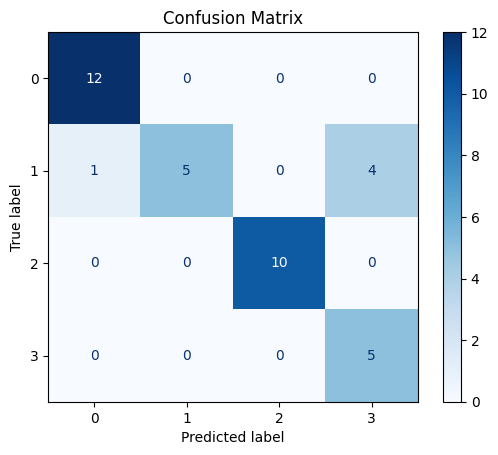

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 印出類別對應的索引
print(test_dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...

# 生成混淆矩阵
cm = confusion_matrix(label_list, pred_list)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(4))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()